# MusicMagus: Zero-Shot Text-to-Music Editing via Diffusion Models

**Authors**: Yixiao Zhang, Yukara Ikemiya, Gus Xia, Naoki Murata, Marco A. Martinez-Ramirez, Wei-Hsiang Liao, Yuki Mitsufuji, Simon Dixon

### This notebook provides a hands-on guide for a live demonstration of [MusicMagus](https://arxiv.org/pdf/2402.06178v3), a music editing/controllable generation approach that leverages pretrained diffusion models.

## Objective: 
### The purpose of this demonstration is to:
- #### Introduce and showcase MusicMagus itself
- #### Familiarize the audience with diffusion model applications and inspire future research directions of diffusion models within the music and audio community!


## What is MusicMagus?
### Music editing/controllable generation method that utilizes a pretrained diffusion model to edit an initial music clip based on certain attributes like *style* or *timbre*.
### From technical perspective, it enables editing by controlling text embeddings and the cross-attention map between the initial and target attributes.

<img src="assets/images/musicmagus.png" alt="description" width="700"/>

## 1. Environmental setups

### Import libraries

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from audioldm2.p2p_pipeline import AudioLDM2Pipeline
from diffusers import DDIMScheduler, DDIMInverseScheduler
import torch
import nltk
nltk.download('punkt_tab')
import IPython
import soundfile as sf
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa 
import librosa.display
import torchaudio
import datetime
import numpy as np
import random
from audioldm2.embedding_calculator import EmbeddingCalculator

# function for visualization
def plot_and_hear(audio, sr, title=''):
    print(title)
    
    # Create the spectrogram using torchaudio
    spectrogram_transform = torchaudio.transforms.Spectrogram(n_fft=1024, power=2)
    spec = spectrogram_transform(audio[0]).cpu()
    plt.figure(figsize=(10, 6))
    
    # Plot the log-scaled spectrogram
    plt.subplot(211)
    plt.title(f"Spectrogram - {title}")
    librosa.display.specshow(torch.log(spec).contiguous().numpy(), sr=sr, x_axis='time', cmap='viridis')
    plt.title('Log Spectrogram')
    
    # Plot the waveform
    plt.subplot(212)
    plt.title(f"Waveform - {title}")
    audio_np = audio.cpu().numpy()[0]
    time_axis = np.linspace(0, len(audio_np) / sr, len(audio_np)) 
    plt.plot(time_axis, audio_np)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 10) 

    # Show the plot
    plt.tight_layout()
    plt.show()

def set_seed(seed):
    """
    Set seed for reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.manual_seed(seed)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Load a pretrained diffusion model
#### Load preatrained [AudioLDM2](https://arxiv.org/pdf/2308.05734) from [diffusers](https://huggingface.co/docs/diffusers/main/en/api/pipelines/audioldm2).

In [2]:
model_ckpt = "cvssp/audioldm2"
pipeline = AudioLDM2Pipeline.from_pretrained(model_ckpt, torch_dtype=torch.float32).to("cuda")
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
RANDOM_SEED = 42

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 11/11 [00:02<00:00,  4.40it/s]


## 2. Playaround AudioLDM2 and create inital music clip

### Music clips can be generated via following steps with AudioLDM2:
- #### Type text prompt at `prompt`.
- #### Set up these hyperparameters (optional):
    - ##### Number of sampling steps at `num_inference_steps` (default: 100 steps with [DDIM](https://arxiv.org/pdf/2010.02502)).
    - ##### Classifier-free guidance scale ([CFG](https://arxiv.org/pdf/2207.12598)) at `guidance_scale` (default: 3.5).
    - ##### Negative prompt at `negative_prompt` (default: "low quality").

### What is CFG? $\rightarrow$ Starndard sampling technique for flexibly controlling generated sample quality and diversity.

##### Using CFG sampling, samples are generated by following this equation:

##### $\nabla_{z_{t}}\log p_{\theta}(z_t |\varnothing) + \omega (\nabla_{z_{t}}\log p_{\theta}(z_t |c) - \nabla_{z_{t}}\log p_{\theta}(z_t |\varnothing))$,
##### or `uncond_score` + $\omega$ (`cond_score` - `uncond_score`)
##### Here, $\omega$ is a CFG scale. Intuitively, this enables guiding the diffusion sampling between `cond_score` and unconditional scores `uncond_score`.

### What is Negative prompt? 
### $\rightarrow$ In practice, it allows us to input a prompt that we want avoid (negative prompt) to the place where we usually input 'blank' for $\varnothing$ in unconditonal score function. 
#### Like $\nabla_{z_{t}}\log p_{\theta}(z_t |c_{negative})$ instad of using $\nabla_{z_{t}}\log p_{\theta}(z_t |\varnothing)$

In [ ]:
set_seed(RANDOM_SEED)
# Set input prompt for AudioLDM2.
prompt = "A smooth jazzy piano playing a heartfelt melody."
# Music generation via AudioLDM2.
audios_init = pipeline.generate(
    prompt,
    negative_prompt="low, bad quality music and audio",
    num_inference_steps=100,
    audio_length_in_s=10,
    guidance_scale=3.5,
    generator=None,
    )

cuda:0


100%|██████████| 100/100 [00:12<00:00,  7.73it/s]


Initial music clip.


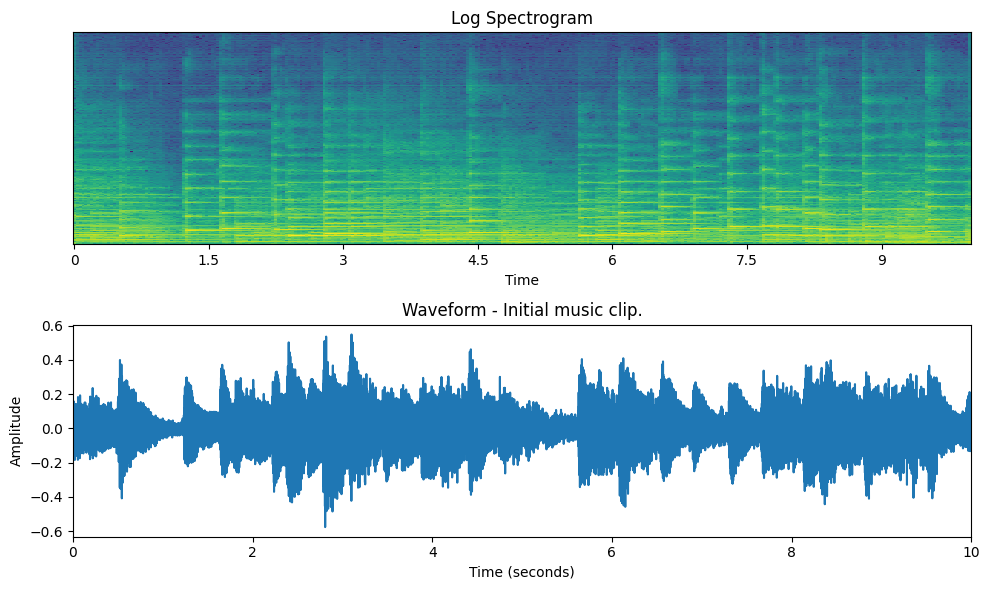

In [4]:
# Plot generated music clip
audios_init = audios_init.audios[0]
plot_and_hear(audios_init.unsqueeze(0), sr=16000, title='Initial music clip.')
current_time = datetime.datetime.now().strftime("%m%d%H%M%S")
# Save 
sf.write(f"outputs/{current_time}_init_music.wav", audios_init, 16000)
IPython.display.display(IPython.display.Audio(audios_init, rate=16000))

## 3. Music editting/controllable generation via MusicMagus
### MusicMagus $\rightarrow$ Utilizes a pretrained diffusion model to edit an initial music clip based on specific attributes like *style* or *timbre*.

### Specifically, the problem setting is as follows:
* #### We start with a music clip generated from an initial text prompt, such as “A smooth jazzy piano playing a heartfelt melody.”
* #### Next, we modify this text prompt by replacing “piano” with “acoustic guitar”, intending to replace the attribute “piano” with “acoustic guitar.”
* #### Our goal is to generate an edited music clip where only the specified attribute is changed, while maintaining other aspects of the original music clip.

### From a technical perspective, it consists of the following two components:
1. #### Compute a difference $\Delta$ between the initial concept and the new concept in the text embedding space to guide the editing direction. (3.1)
2. #### Apply constraints over the cross-attention map during sampling. (3.2)


## 3.1 Calculating Δ
### We want to derive the edited text embedding $E_{\text{edit}}$, from the original text embedding $E_{\text{original}}$.
#### To do that, we compute the difference $\Delta$ between initial concept (`before_concept`) and new concept (`after_concept`).

### In this demo, we replace 'piano' with 'acoustic guitar' as in:
#### 'A smooth jazzy piano playing a heartfelt melody.' $\rightarrow$ 'A smooth jazzy acoustic guitar playing a heartfelt melody.'
### To compute $\Delta$, we use InstructGPT to generate multiple captions related to each attribute. These captions are then input into the text encoder, providing a richer $\Delta$ than relying on a single caption.
##### This is done in `EmbeddingCalculator`.


<img src="assets/images/fig2.png" alt="description" width="600"/>

In [5]:
# Calculating Δ
prompt = "A smooth jazzy piano playing a heartfelt melody."
before_concept = "piano"
after_concept = "acustic guitar"
embedding_calculator = EmbeddingCalculator(embedding_model=pipeline, prompt_length=len(nltk.word_tokenize(prompt)))

# source_embeddings, target_embeddings -> FLAN-T5 embeddings
# generated_source_embeddings, generated_target_embeddings -> GPT-2 embeddings
source_embeddings, generated_source_embeddings, target_embeddings, generated_target_embeddings = embedding_calculator(
    before_concept,
    after_concept,)


source: ['"Melodic, rhythmic, harmonious piano music evokes emotions and stirs the soul."', 'Melodic, intricate, expressive piano pieces that evoke emotion and passion.', '"Melodious keys transport listeners on an emotive musical journey."', 'Melodic, harmonious piano compositions evoking emotions and nostalgia.', 'Melodic, virtuosic, classical, versatile, expressive, keys, composition, captivating, emotional', 'Melodic harmonies flow through lively piano compositions with grace and passion.', '"Melodic, virtuosic piano pieces with majestic chords and lyrical runs."', '"Intimate, melodic piano compositions evoke emotion and mesmerize listeners."', '"Melodic and captivating piano melodies with vibrant composition and delicate harmonies."', '"Elegant melodies, intricate harmonies, and emotive expressions in piano music."', 'Melodic, melancholic melodies evoke emotions over elegant ivory keys.', 'Melodic, soothing, keys, virtuosic, classical, grand, instrument, emotive, enchanting', '"Mel

## 3.2 Conditon $E_{\text{edit}}$ on diffusion models and constraints over the cross-attention map during sampling

#### In AudioLDM2, two embeddings are employed for condition $E_{\text{original}}$: 

#### $E_{\text{original}} = \{E^{\text{original}}_{\text{T5}}, E^{\text{original}}_{\text{GPT}}\}$, with one derived from FLAN-T5 and the other from GPT-2 ([See Fig. 1](https://arxiv.org/pdf/2308.05734) in detail about AudioLDM2 itself).

### During sampling for *edited* samples, the diffusion model is conditioned on $E_{\text{edit}}  = \{{E^{\text{original}}_{\text{T5}} + \Delta, E^{\text{edit}}_{\text{GPT}}\}}$.
##### Note that we do not apply $\Delta$ for $E^{\text{edit}}_{\text{GPT}}$. Instead, we directly input the new text prompt into GPT-2 to obtain the corresponding embedding.

<img src="assets/images/fig3.png" alt="description" width="800"/>

### Additionally, a constraint is applied to the cross-attention map to ensure that only the specified attribute is edited, while other aspects of the original clip remain largely unchanged. 
#### Specifically, during sampling, we add a constraint to minimize $L_{t} = \| M^{\text{edit}}_{t} - M^{\text{original}}_{t} \|_{2}^{2}$.
#### $M^{\text{edit}}_t$ and $M^{\text{original}}_t$ refer to the cross-attention maps calculated by $E_{\text{original}}$ and $E_{\text{edit}}$ respectively, and we take gradients with respect to $z_{t}^{\text{edit}}$.
##### This constraint is adjusted using the hyperparameter `cross_attention_guidance_amount`.
  

In [10]:
# Conditon $E_{\text{edit}}$ on diffusion models and constraints over the cross-attention map during sampling
set_seed(RANDOM_SEED)
print("initial prompt: ", prompt)
# g_cpu = torch.Generator().manual_seed(RANDOM_SEED)

audios_before_, audios_after_ = pipeline(
    prompt,
    negative_prompt="low quality",
    source_embeddings=source_embeddings,
    generated_source_embeddings=generated_source_embeddings,
    target_embeddings=target_embeddings,
    generated_target_embeddings=generated_target_embeddings,
    num_inference_steps=100,
    audio_length_in_s=10,
    guidance_scale=3.5,
    cross_attention_guidance_amount=0.06,
    generator=None,
    # num_waveforms_per_prompt=3,
    before_concept=before_concept,
    after_concept=after_concept,
    latents=None,
    )

initial prompt:  A smooth jazzy piano playing a heartfelt melody.
target_prompt:  A smooth jazzy acustic guitar playing a heartfelt melody.
cuda:0


100%|██████████| 100/100 [00:13<00:00,  7.68it/s]


100%|██████████| 100/100 [00:37<00:00,  2.65it/s]


## 4. Display results

Initial music clip.


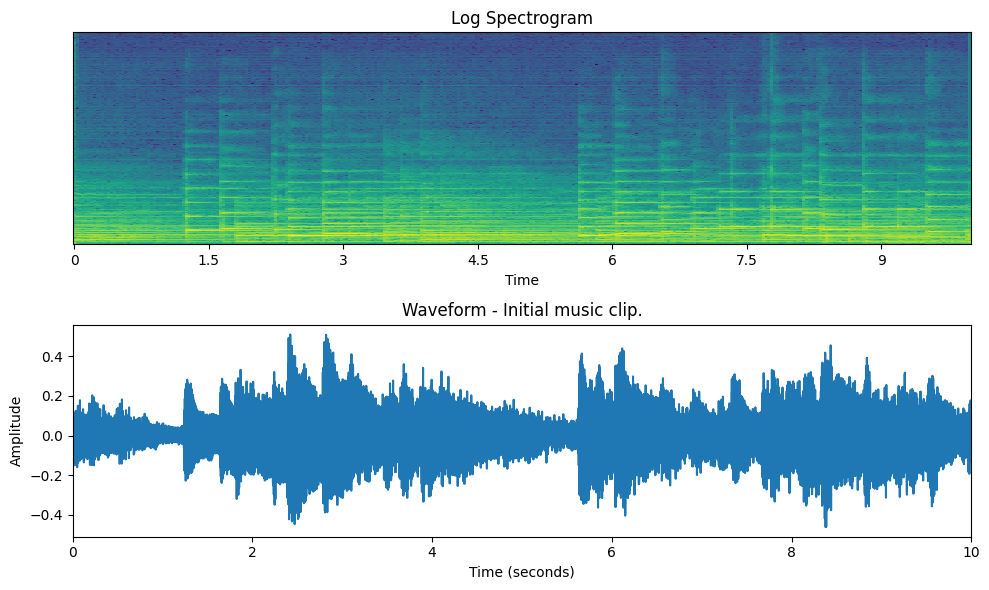

Edited music clip.


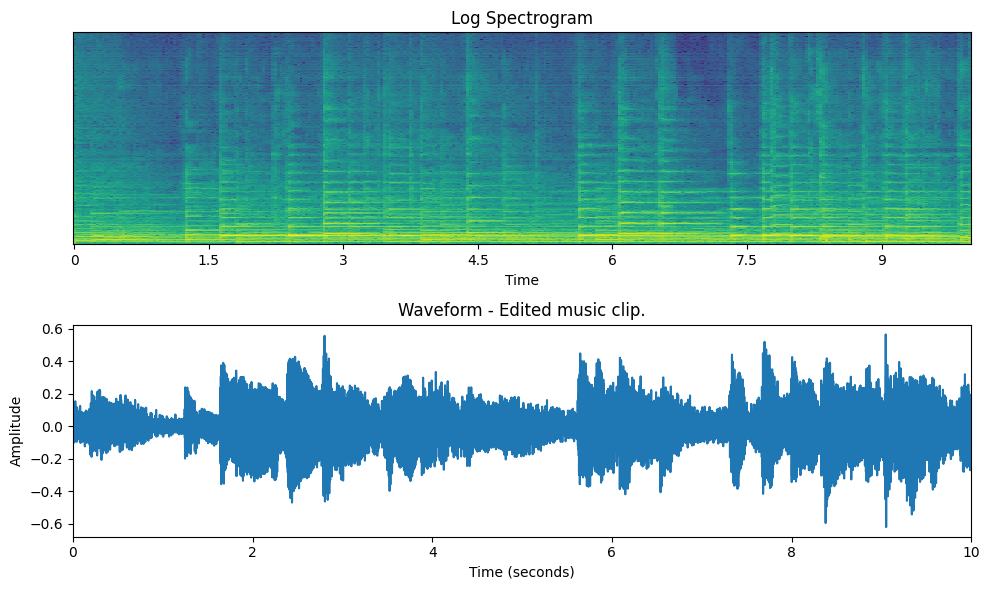

In [11]:
audios_before, audios_after = audios_before_.audios[0], audios_after_.audios[0]
plot_and_hear(torch.from_numpy(audios_before).unsqueeze(0), sr=16000, title='Initial music clip.')
plot_and_hear(torch.from_numpy(audios_after).unsqueeze(0), sr=16000, title='Edited music clip.')

IPython.display.display(IPython.display.Audio(audios_before, rate=16000))
IPython.display.display(IPython.display.Audio(audios_after, rate=16000))

# save
current_time = datetime.datetime.now().strftime("%m%d%H%M%S")
sf.write(f"outputs/{current_time}_{before_concept}_to_{after_concept}_before.wav", audios_before, 16000)
sf.write(f"outputs/{current_time}_{before_concept}_to_{after_concept}_after.wav", audios_after, 16000)


